In [ ]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
import seaborn as sns


import os
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import *
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense


import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


import warnings
warnings.filterwarnings(action="ignore")

In [4]:
os.listdir('/kaggle/input/kidney-diseases-recognition/dataset')


['Cyst', 'Tumor', 'Stone', 'Normal']

In [5]:
path_main = '/kaggle/input/kidney-diseases-recognition/dataset'
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder)) 
    
    print(f'Folder: {folder}')
    print(f'Number of elements: {len(list_of_elements)}')
    print(f'First item\'s name: {list_of_elements[0]}')
    print('***************************\n')

Folder: Cyst
Number of elements: 3709
First item's name: Cyst- (3178).jpg
***************************

Folder: Tumor
Number of elements: 2283
First item's name: Tumor- (1913).jpg
***************************

Folder: Stone
Number of elements: 1377
First item's name: Stone- (209).jpg
***************************

Folder: Normal
Number of elements: 5077
First item's name: Normal- (1381).jpg
***************************



In [6]:
path_normal = '/kaggle/input/kidney-diseases-recognition/dataset/Normal'
path_stone = '/kaggle/input/kidney-diseases-recognition/dataset/Stone'
path_cyst = '/kaggle/input/kidney-diseases-recognition/dataset/Cyst'
path_tumor = '/kaggle/input/kidney-diseases-recognition/dataset/Tumor'

In [7]:
def plot_imgs(item_dir, num_imgs=25):
    
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

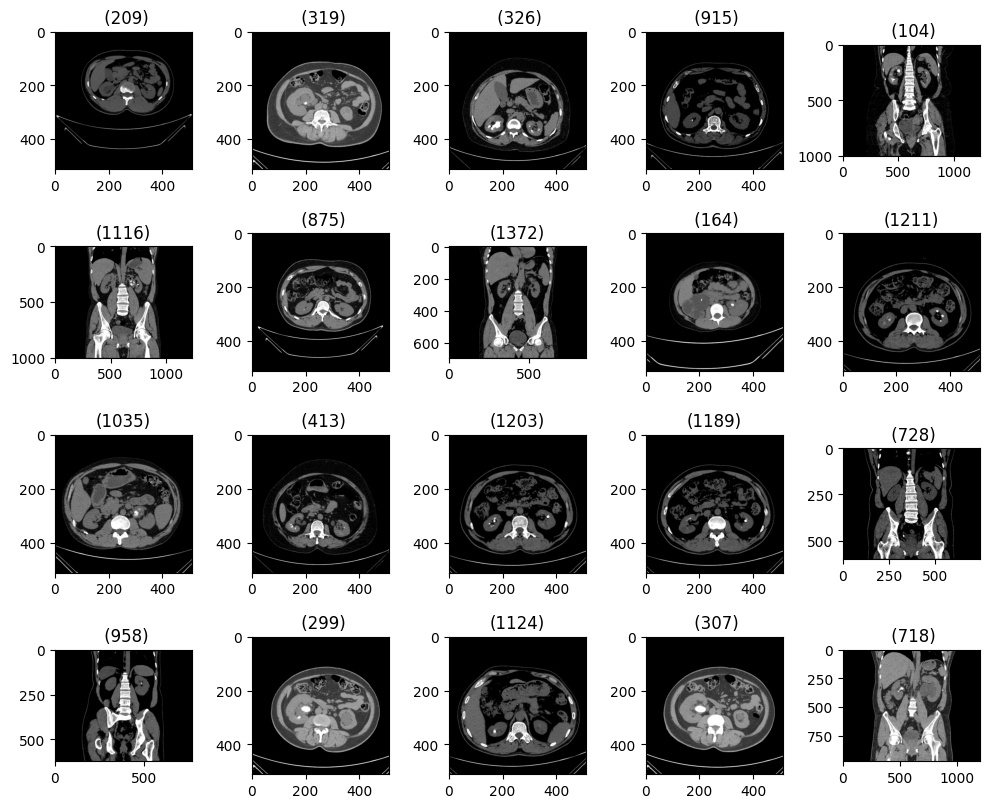

In [8]:
plot_imgs(path_stone, 20)


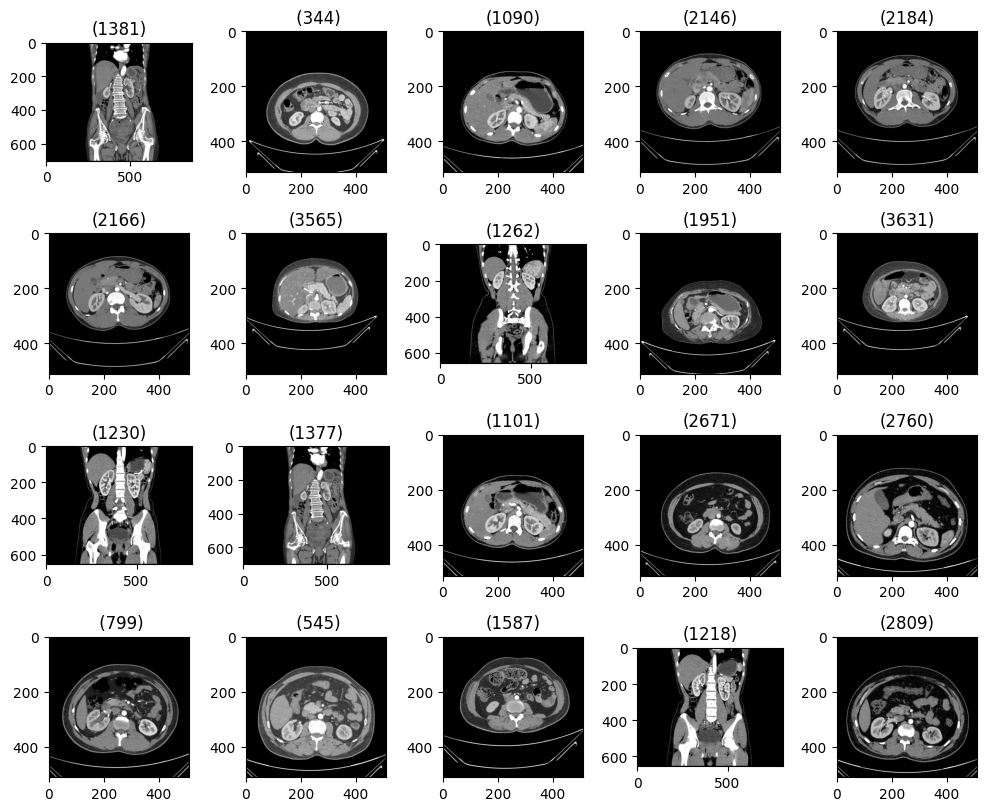

In [9]:
plot_imgs(path_normal, 20)


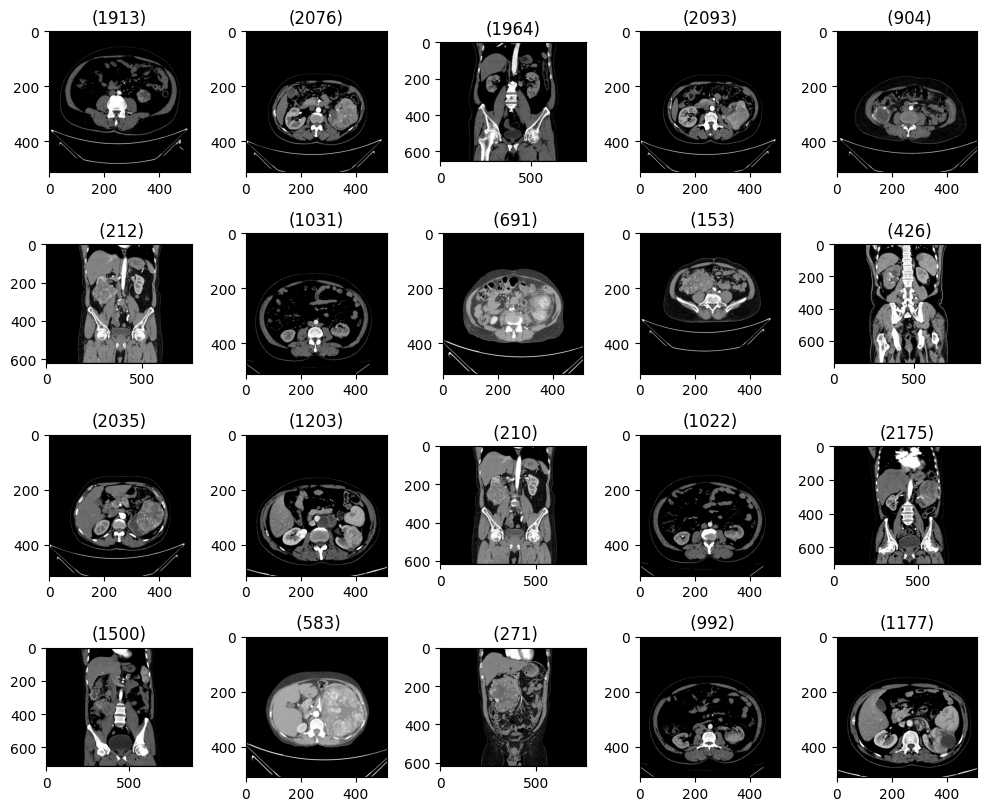

In [10]:
plot_imgs(path_tumor, 20)


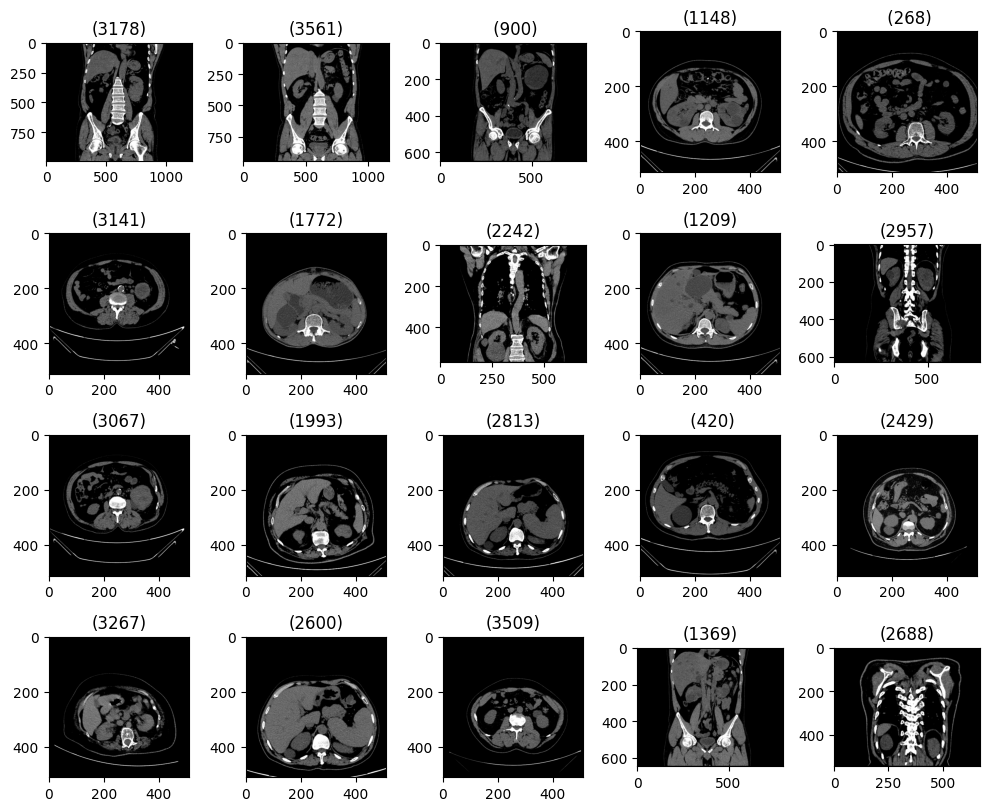

In [11]:
plot_imgs(path_cyst, 20)


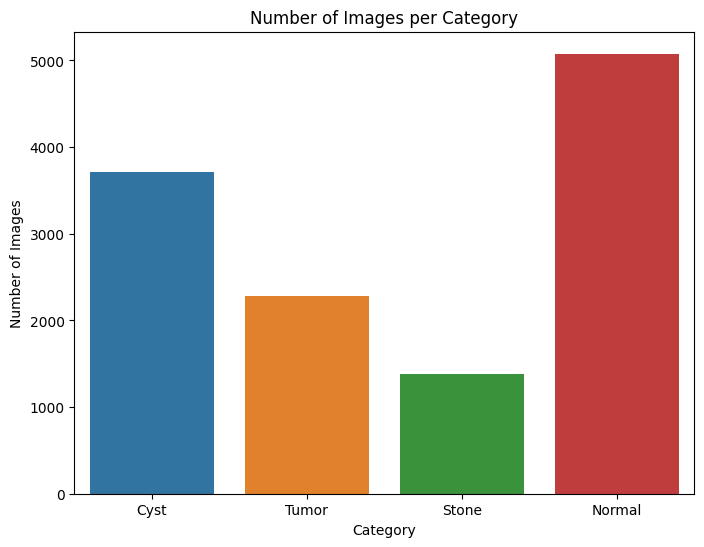

In [21]:
import seaborn as sns
from PIL import Image
categories = ['Cyst', 'Tumor', 'Stone', 'Normal']
num_images = [len(os.listdir(path_cyst)), 
              len(os.listdir(path_tumor)), 
              len(os.listdir(path_stone)), 
              len(os.listdir(path_normal))]

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=num_images)
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()


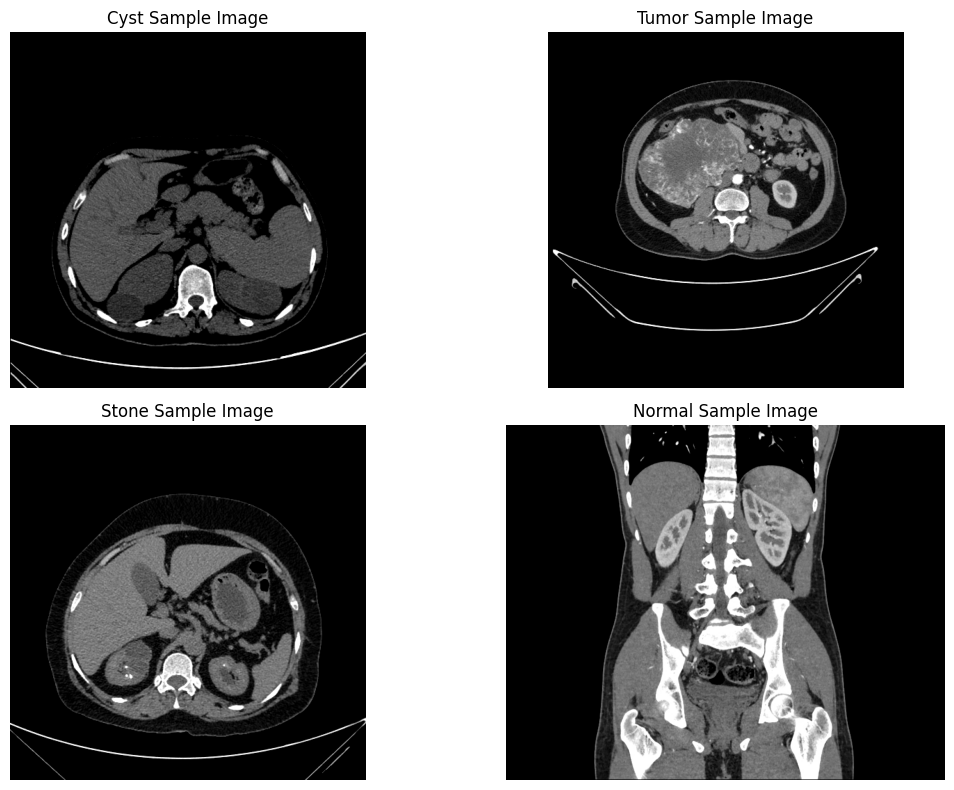

In [22]:
import random
from PIL import Image

def display_sample_images(paths, categories):
    plt.figure(figsize=(12, 8))
    
    for i, (path, category) in enumerate(zip(paths, categories)):
        img_name = random.choice(os.listdir(path))
        img_path = os.path.join(path, img_name)
        
        img = Image.open(img_path)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f'{category} Sample Image')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Define the paths for each category
paths = [path_cyst, path_tumor, path_stone, path_normal]
display_sample_images(paths, categories)


In [23]:
def get_image_sizes(paths):
    image_sizes = {}
    
    for path, category in zip(paths, categories):
        img_name = random.choice(os.listdir(path))
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path)
        image_sizes[category] = img.size
    
    return image_sizes

image_sizes = get_image_sizes(paths)
image_sizes


{'Cyst': (512, 512),
 'Tumor': (768, 622),
 'Stone': (512, 512),
 'Normal': (512, 512)}

In [24]:
def check_corrupted_images(paths):
    corrupted_files = []
    
    for path in paths:
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that the file is an image
            except (IOError, SyntaxError) as e:
                corrupted_files.append(img_path)
    
    return corrupted_files

corrupted_images = check_corrupted_images(paths)
print(f"Number of corrupted images: {len(corrupted_images)}")


Number of corrupted images: 0


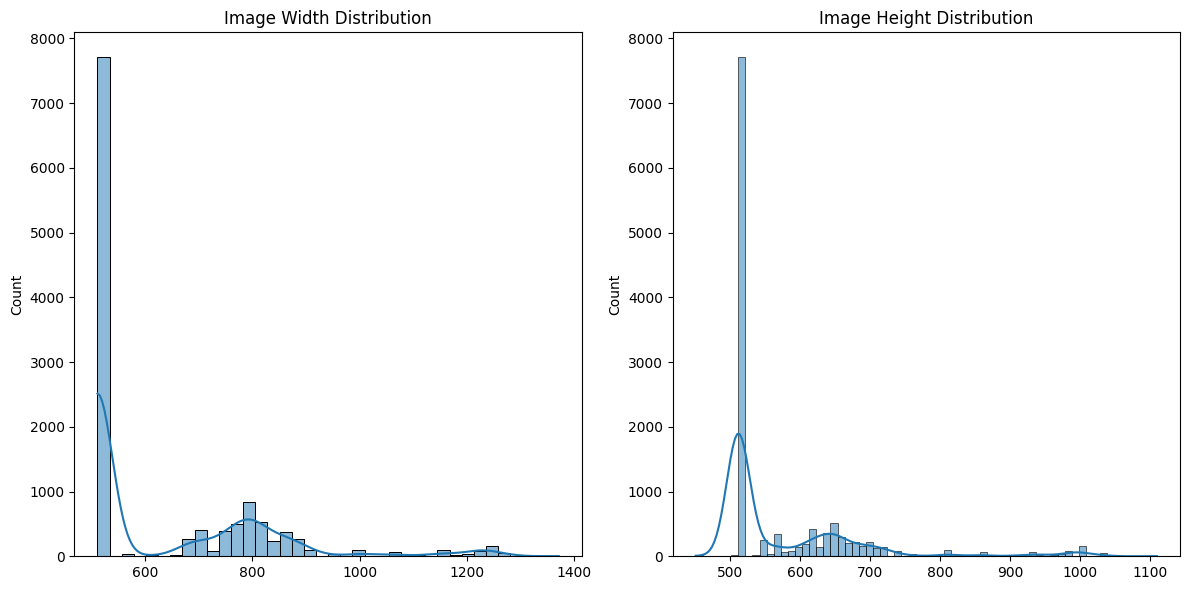

In [25]:
def collect_image_dimensions(paths):
    width_list, height_list = [], []
    
    for path in paths:
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            with Image.open(img_path) as img:
                width, height = img.size
                width_list.append(width)
                height_list.append(height)
    
    return width_list, height_list

widths, heights = collect_image_dimensions(paths)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True)
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True)
plt.title('Image Height Distribution')

plt.tight_layout()
plt.show()


The Image Width Distribution reveals that the majority of the images in the dataset have a width around 400 pixels, with a significant spike at this value. While there are some images with larger widths, ranging up to 1200 pixels, they are much fewer in number, creating a right-skewed distribution. This means most images are relatively small, with only a minority having larger widths.

Similarly, the Image Height Distribution shows a dominant concentration of images between 500-700 pixels in height. Like the width distribution, there are fewer images with larger heights, with some reaching up to 1100 pixels. The overall trend is again right-skewed, indicating that the majority of images are clustered at smaller heights, with fewer larger ones.

These patterns suggest that the images in the dataset are mostly of moderate size, and resizing them to a consistent dimension (like 200x200 pixels, used in your model) would help standardize input for the neural network. The presence of some larger images also implies that proper resizing, cropping, or normalization will be essential to maintain a uniform input structure.

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [13]:
train_dataset = train_datagen.flow_from_directory('/kaggle/input/kidney-diseases-recognition/dataset',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('/kaggle/input/kidney-diseases-recognition/dataset',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('/kaggle/input/kidney-diseases-recognition/dataset',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 12446 images belonging to 4 classes.
Found 12446 images belonging to 4 classes.
Found 12446 images belonging to 4 classes.


In [14]:
model = tf.keras.models.Sequential([
  
    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape), 
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),  # hidden layers 
    
    
    tf.keras.layers.Dense(4, activation='softmax'),
 
])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,345,230 (58.54 MB)

 Trainable params: 5,115,076 (19.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,230,154 (39.02 MB)

In [15]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [16]:
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch = 3,
                      epochs = 30)

Epoch 1/30


I0000 00:00:1727613014.356349     159 service.cc:145] XLA service 0x7f24a0002220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727613014.356426     159 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727613014.356432     159 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/3 ━━━━━━━━━━━━━━━━━━━━ 41s 21s/step - accuracy: 0.2100 - loss: 1.3847 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1727613027.201312     159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 101s 40s/step - accuracy: 0.3321 - loss: 1.3241 - precision: 0.3984 - recall: 0.1487 - val_accuracy: 0.4853 - val_loss: 1.2619 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 24s/step - accuracy: 0.4571 - loss: 1.2668 - precision: 0.4647 - recall: 0.1312 - val_accuracy: 0.5688 - val_loss: 1.2044 - val_precision: 0.7738 - val_recall: 0.0294
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 24s/step - accuracy: 0.5750 - loss: 1.1802 - precision: 0.8803 - recall: 0.0388 - val_accuracy: 0.6139 - val_loss: 1.1118 - val_precision: 0.8372 - val_recall: 0.1822
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 24s/step - accuracy: 0.6308 - loss: 1.0719 - precision: 0.8126 - recall: 0.2925 - val_accuracy: 0.5542 - val_loss: 1.1225 - val_precision: 0.6017 - val_recall: 0.4480
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 25s/step - accuracy: 0.6087 - loss: 1.0167 - precision: 0.6828 - recall: 0.5183 - val_accuracy: 0.6627 - val_loss: 0.9448 - val_precis

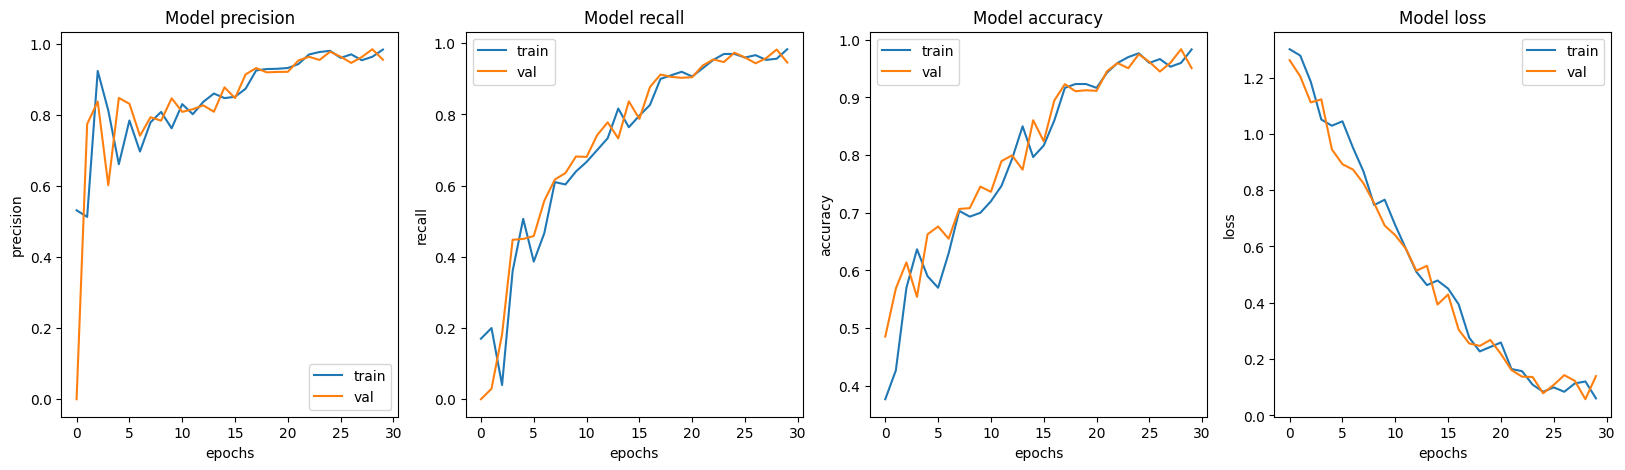

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(model_fit.history[met])
    ax[i].plot(model_fit.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
predictions = model.predict(test_dataset)


125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 384ms/step


In [26]:
def evaluate(actual, predictions):
    pre = []
    for i in predictions:
        pre.append(np.argmax(i))

    accuracy = (pre == actual).sum() / actual.shape[0]
    print(f'Accuracy: {accuracy}')

    precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')

    fig, ax = plt.subplots(figsize=(20,20))
    conf_mat = confusion_matrix(actual, pre)
    sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="plasma", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
    plt.show()

Accuracy: 0.950827575124538
Precision: 0.9647450806124246
Recall: 0.898118649779069
F1_score: 0.9214783452403071


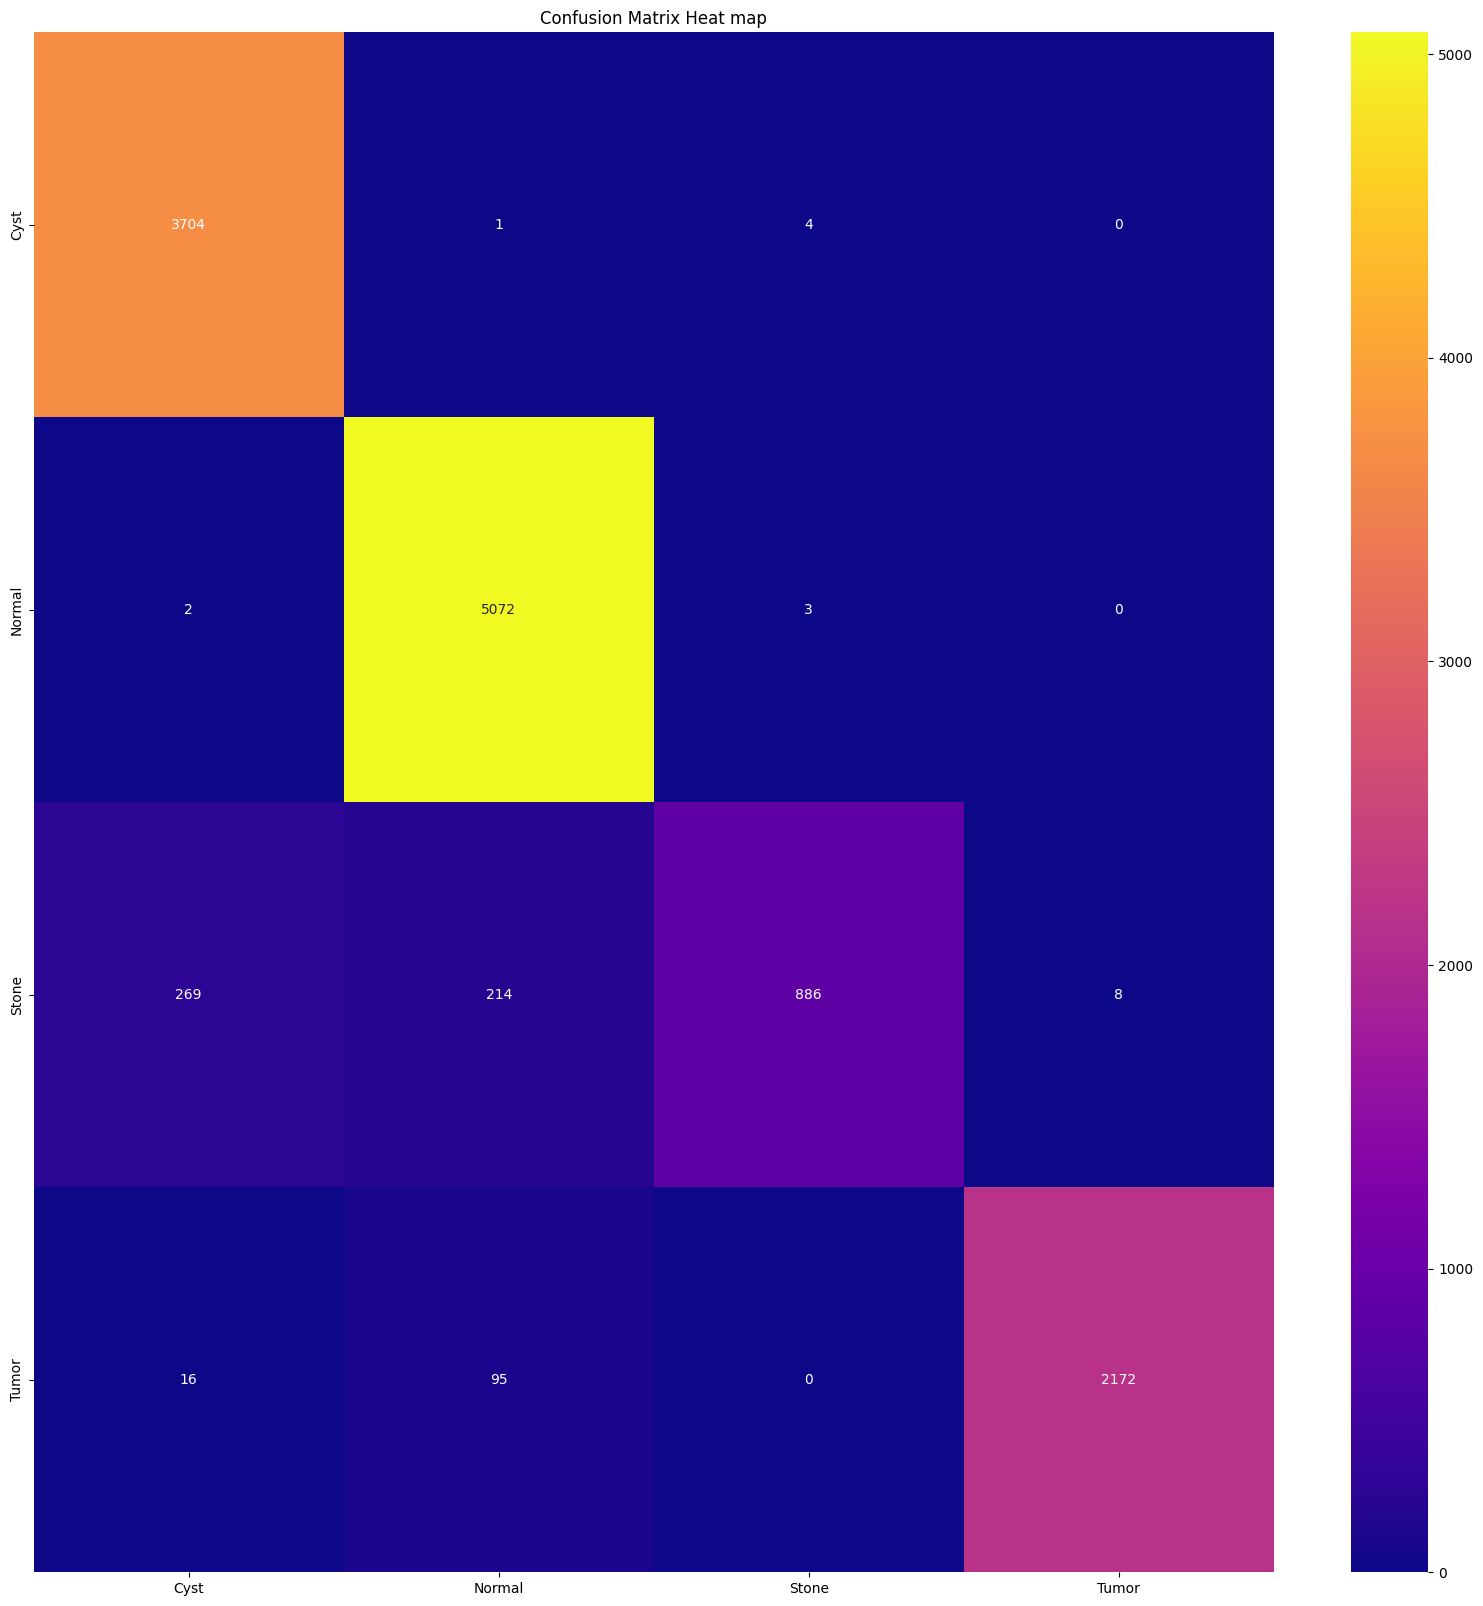

In [20]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
    diseases_labels.append(key)

evaluate(test_dataset.classes,predictions)

In [27]:
model.evaluate(test_dataset)


125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.9870 - loss: 0.0383 - precision: 0.9883 - recall: 0.9855


[0.13962504267692566,
 0.9508275985717773,
 0.9547518491744995,
 0.9460067749023438]